In [1]:
import os
import numpy as np

BBO_experiments_dict = {
    "BBO 10 restarts;ShgC/DotP (baseline)": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v4_no_cache_obabel/12.03_optim_HOMO_value_baseline_CONF9",
    "BBO MBTR/RBF": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v4_no_cache_obabel/12.04_optim_HOMO_value_MBTR_RBF_CONF9"
}

EvoMol_experiments_dict = {
    "EvoMol": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v4_no_cache_obabel/12.01_EvoMol_from_methane_optim_HOMO_value_CONF9",
    "EvoMol RDKit MM + cache": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v3/01.01_EvoMol_from_methane_optim_HOMO_10_runs"
}

sub_experiments_names = [str(i) for i in range(1, 11)]

ECDF_TARGETS = np.arange(-10, -1, 0.01)
ERT_TARGETS = np.arange(-10, -1, 0.5)

In [2]:
groups = [
    (
         "All", 
         ["EvoMol", "EvoMol RDKit MM + cache", "BBO 10 restarts;ShgC/DotP (baseline)", "BBO MBTR/RBF"],
         {
         }
    ),
]


In [3]:
from bbo.postprocessing import extract_multiple_BBO_experiments_data, extract_multiple_evomol_experiments_data

def extract_all_data(BBO_experiments_dict, EvoMol_experiments_dict, sub_experiments_names):
    
    results_dict = {}
    
    for exp_name, path in BBO_experiments_dict.items():
        results_dict[exp_name] = extract_multiple_BBO_experiments_data(path, sub_experiments_names)
        
    for exp_name, path in EvoMol_experiments_dict.items():
        results_dict[exp_name] = extract_multiple_evomol_experiments_data(path, sub_experiments_names)

    return results_dict

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from bbo.evaluation import compute_ecdf

def plot_ECDF(results_dict, plot_title=None, exp_list_plot=None, exp_list_details=None, labels_dict=None):
    
    colors = sns.color_palette()
    
    plt.figure(figsize=(15, 8))
    if plot_title is not None:        
        plt.title(plot_title)
    
    plt.xlim(1, 1100)
    plt.ylim(0, 1)
    plt.xlabel("# DFT calls")
    plt.ylabel("Proportion of targets achieved")
    
    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())
    
    for i, experiment_name in enumerate(exp_list_plot):
        
        if experiment_name in exp_list_plot:
            
            if labels_dict is not None and experiment_name in labels_dict:
                display_experiment_name = labels_dict[experiment_name]
            else:
                display_experiment_name = experiment_name
        
            for j in range(len(results_dict[experiment_name]["dataset_success_n_calls"])):

                if exp_list_details is not None and experiment_name in exp_list_details:
                    obj_calls, ecdf_vect = compute_ecdf(
                        obj_calls_list=[results_dict[experiment_name]["dataset_success_n_calls"][j]],
                        obj_values_list=[results_dict[experiment_name]["dataset_success_obj_value"][j]],
                        targets=ECDF_TARGETS
                    )
                    sns.lineplot(obj_calls, ecdf_vect, label=display_experiment_name, color=colors[i], 
                                 dashes=[(2, 2)], style=True)
                    plt.scatter([obj_calls[-1]], [ecdf_vect[-1]], color="black")

            obj_calls, ecdf_vect = compute_ecdf(
                obj_calls_list=results_dict[experiment_name]["dataset_success_n_calls"],
                obj_values_list=results_dict[experiment_name]["dataset_success_obj_value"],
                targets=ECDF_TARGETS
            )

            sns.lineplot(obj_calls, ecdf_vect, label=display_experiment_name, color=colors[i])
            plt.legend(loc='lower left')
        
    plt.show()

In [5]:
from bbo.evaluation import compute_ERT
import pandas as pd
from IPython.display import display, HTML

def display_ERT(results_dict, plot_title=None, exp_list_plot=None, labels_dict=None):
    
    output_keys = ["Experiment"] + [str(value) for value in ERT_TARGETS]
    ERT_dict = {output_key: [] for output_key in output_keys}
    
    if plot_title is not None:
        display(HTML("<h3>" + plot_title +"</h3>"))

    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())
    
    for i, experiment_name in enumerate(exp_list_plot):
        
        if labels_dict is not None and experiment_name in labels_dict:
            display_experiment_name = labels_dict[experiment_name]
        else:
            display_experiment_name = experiment_name
        
        ERT_vect = compute_ERT(
            obj_calls_list=results_dict[experiment_name]["dataset_success_n_calls"],
            obj_values_list=results_dict[experiment_name]["dataset_success_obj_value"],
            targets=ERT_TARGETS
        )
        
        ERT_dict["Experiment"].append(display_experiment_name)
        for j in range(len(ERT_vect)):
            ERT_dict[output_keys[j+1]].append(ERT_vect[j])
    
    df = pd.DataFrame.from_dict(ERT_dict)
    display(df)

In [6]:
import itertools

def display_stable_proportion(results_dict, plot_title=None, exp_list_plot=None, labels_dict=None):
    
    output_keys = ["Experiment", "# Stable", "# Generated", "Stable proportion (%)", "# Unique stable",
                   "# Unique generated", "Unique stable proportion (%)", "Unique stable ∩ unstable"]
    output_dict = {output_key: [] for output_key in output_keys}
    
    if plot_title is not None:
        display(HTML("<h3>" + plot_title +"</h3>"))

    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())
        
    for i, experiment_name in enumerate(exp_list_plot):

        if labels_dict is not None and experiment_name in labels_dict:
            display_experiment_name = labels_dict[experiment_name]
        else:
            display_experiment_name = experiment_name
            
        stable_smiles = list(itertools.chain(*results_dict[experiment_name]["dataset_success_smiles"]))
        unstable_smiles = list(itertools.chain(*results_dict[experiment_name]["dataset_failed_smiles"]))
            
        stable_smiles_unique = list(np.unique(stable_smiles))
        unstable_smiles_unique = list(np.unique(unstable_smiles))
        
        intersection = np.intersect1d(stable_smiles_unique, unstable_smiles_unique)
            
        n_stable = len(stable_smiles)
        n_unstable = len(unstable_smiles)
        n_unique_stable = len(stable_smiles_unique)
        n_unique_unstable = len(unstable_smiles_unique)
        
        total_smiles = n_stable + n_unstable
        total_unique_smiles = n_unique_stable + n_unique_unstable

        stable_prop = n_stable / total_smiles * 100
        unique_stable_prop = n_unique_stable / total_unique_smiles * 100
        
        output_dict["Experiment"].append(display_experiment_name)
        
        output_dict["# Stable"].append(n_stable)
        output_dict["# Generated"].append(total_smiles)
        output_dict["Stable proportion (%)"].append(stable_prop)

        output_dict["# Unique stable"].append(n_unique_stable)
        output_dict["# Unique generated"].append(total_unique_smiles)
        output_dict["Unique stable proportion (%)"].append(unique_stable_prop)
        
        output_dict["Unique stable ∩ unstable"].append(len(intersection))
    
    df = pd.DataFrame.from_dict(output_dict)
    display(df)

In [7]:
def display_times(results_dict, plot_title=None, exp_list_plot=None, labels_dict=None):

    output_keys = ["Experiment", "Mean step time", "Mean optim. time", "Mean desc. obj. comput. time"]
    output_dict = {output_key: [] for output_key in output_keys}
    
    if plot_title is not None:
        display(HTML("<h3>" + plot_title +"</h3>"))

    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())

    for i, experiment_name in enumerate(exp_list_plot):

        if labels_dict is not None and experiment_name in labels_dict:
            display_experiment_name = labels_dict[experiment_name]
        else:
            display_experiment_name = experiment_name
            
        if "steps_step_duration" in results_dict[experiment_name]:
            mean_step_time = np.mean(list(itertools.chain(*results_dict[experiment_name]["steps_step_duration"])))
            mean_optim_time = np.mean(list(itertools.chain(*results_dict[experiment_name]["steps_optim_duration"])))
            mean_desc_obj_time = np.mean(list(itertools.chain(*results_dict[experiment_name]["steps_desc_obj_comput_duration"])))
        else:
            mean_step_time = None
            mean_optim_time = None
            mean_desc_obj_time = None
        
        output_dict["Experiment"].append(display_experiment_name)
        output_dict["Mean step time"].append(mean_step_time)
        output_dict["Mean optim. time"].append(mean_optim_time)
        output_dict["Mean desc. obj. comput. time"].append(mean_desc_obj_time)
        
    df = pd.DataFrame.from_dict(output_dict)
    display(df)
        

In [8]:
results_dict = extract_all_data(BBO_experiments_dict, EvoMol_experiments_dict, sub_experiments_names)

# ECDF (Empirical cumulative distribution functions)

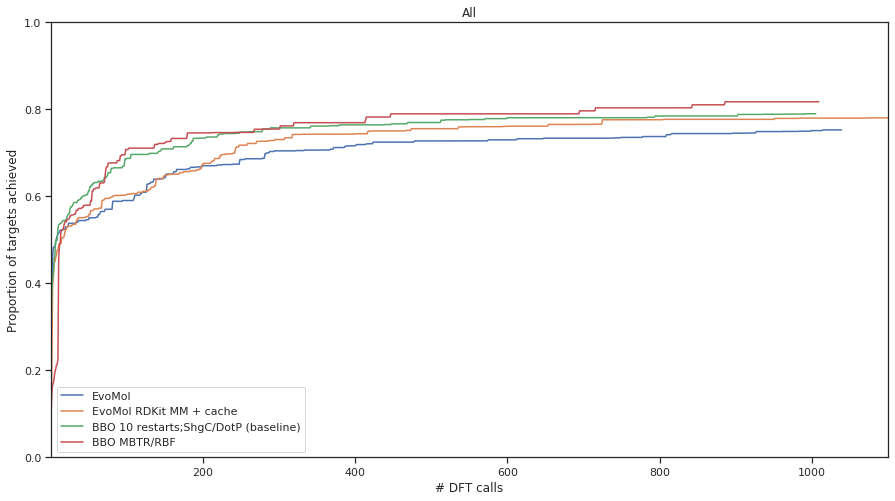

In [9]:
for group in groups:
    plot_ECDF(results_dict, group[0], group[1], labels_dict=group[2])

# ERT (Expected running time)

In [10]:
for group in groups:
    display_ERT(results_dict, group[0], group[1], labels_dict=group[2])

Experiment  -10.0  -9.5  -9.0  -8.5  -8.0  -7.5  \
0                                EvoMol    1.1   1.1   1.4   1.4   1.4   1.4   
1               EvoMol RDKit MM + cache    1.7   1.7   2.2   2.5   2.6   3.0   
2  BBO 10 restarts;ShgC/DotP (baseline)    1.2   1.2   1.2   1.4   2.3   2.6   
3                          BBO MBTR/RBF    1.1   1.5   1.8   3.1  10.2  10.8   

   -7.0  -6.5  -6.0  -5.5  -5.0   -4.5   -4.0        -3.5     -3.0    -2.5  \
0   1.5   2.4   2.5  12.0  35.4  145.6  289.5  525.111111      inf     inf   
1   3.5   4.7   6.1  13.0  34.4  142.7  194.4  285.100000  1086.20  8373.0   
2   3.1   3.7   4.3   8.6  19.9   52.7  112.4  189.400000  1780.75     inf   
3  11.7  12.3  12.9  14.6  16.4   69.5   98.5  154.900000   521.80     inf   

   -2.0  -1.5  
0   inf   inf  
1   inf   inf  
2   inf   inf  
3   inf   inf

# Times

In [11]:
for group in groups:
    display_times(results_dict, group[0], group[1], labels_dict=group[2])

Experiment  Mean step time  Mean optim. time  \
0                                EvoMol             NaN               NaN   
1               EvoMol RDKit MM + cache             NaN               NaN   
2  BBO 10 restarts;ShgC/DotP (baseline)      490.338328          8.783355   
3                          BBO MBTR/RBF      662.631948        319.492002   

   Mean desc. obj. comput. time  
0                           NaN  
1                           NaN  
2                    481.114444  
3                    339.491015

# Proportion of stable solutions 

In [12]:
for group in groups:
    display_stable_proportion(results_dict, group[0], group[1], labels_dict=group[2])

Experiment  # Stable  # Generated  \
0                                EvoMol      7659        10038   
1               EvoMol RDKit MM + cache     22217        30478   
2  BBO 10 restarts;ShgC/DotP (baseline)      4154        10010   
3                          BBO MBTR/RBF      6206        10010   

   Stable proportion (%)  # Unique stable  # Unique generated  \
0              76.300060             5507                7115   
1              72.895203            10507               15108   
2              41.498501             3239                7875   
3              61.998002             4063                5519   

   Unique stable proportion (%)  Unique stable ∩ unstable  
0                     77.399859                        23  
1                     69.545936                        37  
2                     41.130159                        37  
3                     73.618409                       118

Plot évolution stabilité